# Distinguising Supersymmetric Particles from Background

In [1]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Step 1: Load and Split the Data

Write a function `load_and_split_data(filename, train_ratio=0.7)` whose functionality is to load and split the data
for a specific ratio of train and validation data (we won't use a third test dataset for now, which we would need to make a final assessment)

In [2]:
def load_and_split_data(filename, train_ratio=0.7):
    data = pd.read_csv(filename).to_numpy()
    maxidx = int(len(data) * train_ratio)
    train_data = data[:maxidx]
    valid_data = data[maxidx:]
    return train_data, valid_data

def make_data(dataset, N = 100):
    dataX, datay = dataset[:,1:], dataset[:,:1]
    idx = np.random.choice(np.arange(len(dataX)), size = N, replace=True)
    return torch.FloatTensor(dataX[idx]), torch.FloatTensor(datay[idx])

In [3]:
! curl https://cernbox.cern.ch/s/5tNCYXcrW5Wd9xf/download -o SUSY_small.csv

train_data, valid_data = load_and_split_data('SUSY_small.csv',0.7)

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 13.6M    0 13.6M    0     0  3334k      0 --:--:--  0:00:04 --:--:-- 3335k


## Visualize the Dataset

It's always good to visualize the data before starting to do crazy machine learning with it. This is
sometimes referred to as exploratory data analysis (EDA) and is useful to catch e.g. vastly diverging
scales between features

Visualize the 18 data features on 18 panels, where on each panel you have two histograms
* the distribution of the feature for y == 0
* the distribution of the feature for y == 1

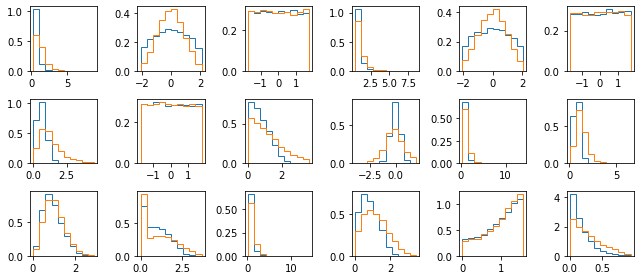

In [4]:
def plot_dataset(axarr,dataset):
    dataX, datay = dataset[:,1:], dataset[:,:1]
    for idx,ax in enumerate(axarr.ravel()[:dataset.shape[1]]):
        _,bins,_ = ax.hist(dataX[datay[:,0]==0,idx], histtype = 'step', density = True)
        _,bins,_ = ax.hist(dataX[datay[:,0]==1,idx], bins = bins, histtype = 'step', density = True)
f,axarr = plt.subplots(3,6)
plot_dataset(axarr,train_data)
f.set_size_inches(9,4)
f.set_tight_layout(True)

## Create a function that creates a simple MLP

The neural network should have width N hidden layers and use ReLU activations internally and finish up with a sigmoid activation


In [5]:
def make_model(N = 512):
    net = torch.nn.Sequential(
        torch.nn.Linear(18,N),
        torch.nn.ReLU(),
        torch.nn.Linear(N,N),
        torch.nn.ReLU(),
        torch.nn.Linear(N,1),
        torch.nn.Sigmoid()
    )
    return net

## Create a Training Loop



In [6]:
def train(train_data):
    net = make_model()
    opt = torch.optim.Adam(net.parameters(),1e-3)
    traj = []
    for i in range(3000):
        X,Y = make_data(train_data, 1000)
        p = net(X)
        train_loss = torch.nn.functional.binary_cross_entropy(p,Y)
        train_loss.backward()
        opt.step()
        opt.zero_grad()

        traj.append(float(train_loss))
        if i % 100  == 0:
            print(f'step: {i} loss: {float(train_loss):.3f}')
    traj = np.array(traj)
    return net, traj

## Train the Model

step: 0 loss: 0.686
step: 100 loss: 0.413
step: 200 loss: 0.447
step: 300 loss: 0.415
step: 400 loss: 0.457
step: 500 loss: 0.428
step: 600 loss: 0.424
step: 700 loss: 0.420
step: 800 loss: 0.382
step: 900 loss: 0.410
step: 1000 loss: 0.377
step: 1100 loss: 0.371
step: 1200 loss: 0.360
step: 1300 loss: 0.357
step: 1400 loss: 0.339
step: 1500 loss: 0.398
step: 1600 loss: 0.360
step: 1700 loss: 0.379
step: 1800 loss: 0.332
step: 1900 loss: 0.352
step: 2000 loss: 0.351
step: 2100 loss: 0.303
step: 2200 loss: 0.313
step: 2300 loss: 0.320
step: 2400 loss: 0.313
step: 2500 loss: 0.282
step: 2600 loss: 0.286
step: 2700 loss: 0.311
step: 2800 loss: 0.261
step: 2900 loss: 0.256


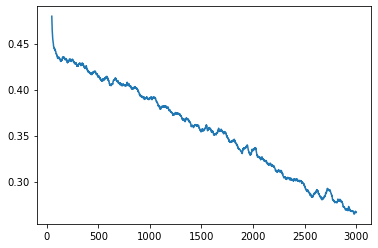

In [7]:
net, traj = train(train_data)
plt.plot(pd.Series(traj).rolling(50).mean())

## Wait a minute - Evaluate the True Performance

In [8]:
def eval_model(net, data):
    with torch.no_grad():
        X,Y = make_data(data, 1000)
        p = net(X)
        loss = torch.nn.functional.binary_cross_entropy(p,Y)
    return loss

In [9]:
eval_model(net, valid_data)

tensor(0.5862)

## 👀 - seems like we can't trust the train performance

Write an improved training loop that also tracks the validation performance

step: 0 loss: 0.697
step: 100 loss: 0.452
step: 200 loss: 0.474
step: 300 loss: 0.384
step: 400 loss: 0.404
step: 500 loss: 0.452
step: 600 loss: 0.464
step: 700 loss: 0.416
step: 800 loss: 0.396
step: 900 loss: 0.406
step: 1000 loss: 0.422
step: 1100 loss: 0.389
step: 1200 loss: 0.381
step: 1300 loss: 0.408
step: 1400 loss: 0.367
step: 1500 loss: 0.347
step: 1600 loss: 0.378
step: 1700 loss: 0.331
step: 1800 loss: 0.382
step: 1900 loss: 0.329
step: 2000 loss: 0.335
step: 2100 loss: 0.317
step: 2200 loss: 0.318
step: 2300 loss: 0.343
step: 2400 loss: 0.312
step: 2500 loss: 0.311
step: 2600 loss: 0.267
step: 2700 loss: 0.315
step: 2800 loss: 0.303
step: 2900 loss: 0.271


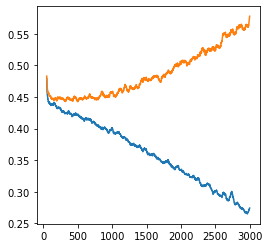

In [10]:
def train(train_data, test_data):
    net = make_model()
    opt = torch.optim.Adam(net.parameters(),1e-3)
    traj = []
    for i in range(3000):
        X,Y = make_data(train_data, 1000)
        p = net(X)
        train_loss = torch.nn.functional.binary_cross_entropy(p,Y)
        train_loss.backward()
        opt.step()
        opt.zero_grad()

        test_loss = eval_model(net, test_data)



        traj.append([float(train_loss), float(test_loss)])
        if i % 100  == 0:
            print(f'step: {i} loss: {float(train_loss):.3f}')
    traj = np.array(traj)
    return net, traj

net, traj = train(train_data, valid_data)
plt.plot(pd.Series(traj[:,0]).rolling(50).mean())
plt.plot(pd.Series(traj[:,1]).rolling(50).mean())
plt.gcf().set_size_inches(4,4)

## Getting the ROC curve

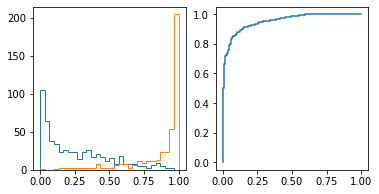

In [11]:
import sklearn.metrics as metrics
def plot_distribution(dataset, model):
    f, axarr = plt.subplots(1,2)
    f.set_size_inches(6,3)
    X,Y = make_data(dataset, 1000)
    with torch.no_grad():
        p = net(X)
    bins = np.linspace(0,1,31)
    ax = axarr[0]
    ax.hist(p[Y==0], histtype = 'step', bins = bins)
    ax.hist(p[Y==1], histtype = 'step', bins = bins)
    
    ax = axarr[1]
    a,b,c = metrics.roc_curve(Y,p)
    ax.plot(a,b)

plot_distribution(train_data, net)